# Load the cleaned data

In [1]:
import pandas as pd

In [2]:
grouped_dialogue_path = "D:/MACSS PROGRAM/30122/MACS-60000-2024-Winter/data/Arknights_plot/grouped_dialogues.csv"
grouped_df = pd.read_csv(grouped_dialogue_path)

In [3]:
grouped_df.sample(12)

,Story,Character,Dialogue
77000,act26side_Hortus de Escapismo,Clément,So that's why you don't like it.
81424,act5d0_Code of Brawl,Exusiai,——
46397,act16d5_Who Is Real,Ink Spirit,Gkhaa!
12348,main_6_Partial Necrosis,???,"Goodbye then, Miss Blaze, Superintendent Ch'en."
52371,act17side_Stultifera Navis,Jordi,Sir... I don't want to. I want to stay here.
13493,main_7_The Birth of Tragedy,Firewatch,To die for someone else... Not all knights...
14870,main_8_Roaring Flare,Alina,Talulah! Come back! Don't! Is that... fire...
75175,act25side_Lone Trail,Rosmontis,Like... like this?
51550,act17side_Stultifera Navis,Indiscreet Townsfolk,You... You knew Juan was a member of the Churc...
51113,act17side_Stultifera Navis,Thiago,......


In [7]:
grouped_df[grouped_df['Character'] == 'non-character']

,Story,Character,Dialogue
0,main_0_Evil Time Part 1,non-character,It's been a long time since we've last seen...
456,main_10_Shatterpoint,non-character,"Londinium, Auchterigg Borough Inside The Shard"
484,main_10_Shatterpoint,non-character,「I'll return to the city's outer barracks soon...
494,main_10_Shatterpoint,non-character,"6:50 A.M. \ Overcast 527km out from Londinium,..."
531,main_10_Shatterpoint,non-character,7:25 A.M. \ Overcast Ten kilometers from Londi...
...,...,...,...
88467,act9mini_Pinus Sylvestris,non-character,The spokesman has been yelling at us for over ...
88476,act9mini_Pinus Sylvestris,non-character,I knew that he felt something for his target. ...
88478,act9mini_Pinus Sylvestris,non-character,"Put on the spot like that, I can't knee-jerk a..."
88480,act9mini_Pinus Sylvestris,non-character,"And then he leaves. And there's Centaurea, who..."


I'm trying to convert my data on game plot (from a pandas dataframe) to an utterance df that can be make into corpus in ConvoKit.

My dataframe have 3 columns: 'Story' (name of the story where dialogues happened), 'Character', 'Dialogue'; also, you can consider the dataframe to be ordered in time series, if you read along the index in order, that's what you experienced in game.

Now, to instantiate an utterance object, we generally need the following information (all ids should be of type string):

- id: representing the unique id of the utterance. [we don't have this, need a way to generate one for each row]
- speaker: a ConvoKit speaker object representing the speaker giving the utterance. [this is the character, we can use the Character name for this]
- root: the id of the root utterance of the conversation. [I'll give my insight of denoting conversation below]
- reply_to: id of the utterance this was a reply to. [Let's put None for all rows now]
- timestamp: timestamp of the utterance. [We don't have it, probably we can have some numbers in increasing order for this for all rows since its in order]
- text: text of the utterance. [the Dialogue]

In [7]:
import pandas as pd
from convokit import Corpus, Speaker, Utterance

# grouped_df have 'Story', 'Character', and 'Dialogue' columns

# Initialize variables for conversation tracking
current_conversation_id = None
previous_character = None

# List to hold the utterance objects
utterances = []

for idx, row in grouped_df.iterrows():
    # Generate a unique ID for the utterance
    utterance_id = f"utt_{idx}"
    
    # Check if the current row signifies a new conversation
    if row['Character'] == "non-character" or previous_character == "non-character":
        current_conversation_id = utterance_id

    # Create a Speaker object (for now, just using the name)
    speaker = Speaker(id=row['Character'])
    
    # Create an Utterance object
    utterance = Utterance(
        id=utterance_id,
        speaker=speaker,
        conversation_id=current_conversation_id,
        reply_to=None, 
        timestamp=idx,  # Using the index as a simple timestamp
        text=row['Dialogue'],
        meta={'story': row['Story']}
    )

    # Add the utterance to the list
    utterances.append(utterance)

    # Update the previous character for the next iteration
    previous_character = row['Character']

# Create the Corpus
corpus = Corpus(utterances=utterances)

In [8]:
corpus.print_summary_stats()

Number of Speakers: 2031
Number of Utterances: 88493
Number of Conversations: 6405


In [10]:
characters_df = corpus.get_speakers_dataframe()
characters_df

,vectors
id,
non-character,[]
Distant Voice,[]
???,[]
Medic,[]
Amiya,[]
...,...
Malkiewicz,[]
Knight Scout,[]
Centaurea,[]


In [11]:
# Initialize a dictionary to keep track of utterance counts for each character
character_utterance_count = {}

# Iterate through all utterances in the corpus
for utterance in corpus.iter_utterances():
    # Get the speaker ID (character name)
    speaker_id = utterance.speaker.id
    
    # Increment the count for this speaker
    if speaker_id in character_utterance_count:
        character_utterance_count[speaker_id] += 1
    else:
        character_utterance_count[speaker_id] = 1

# Update the speaker metadata with the utterance count
for speaker_id, count in character_utterance_count.items():
    corpus.get_speaker(speaker_id).meta['utterance_count'] = count

# Similarly, for conversation metadata (e.g., counting utterances per conversation)
conversation_utterance_count = {}

for utterance in corpus.iter_utterances():
    # Get the conversation ID
    conversation_id = utterance.conversation_id
    
    # Increment the count for this conversation
    if conversation_id in conversation_utterance_count:
        conversation_utterance_count[conversation_id] += 1
    else:
        conversation_utterance_count[conversation_id] = 1

# Update the conversation metadata with the utterance count
for conversation_id, count in conversation_utterance_count.items():
    corpus.get_conversation(conversation_id).meta['utterance_count'] = count


In [19]:
characters_df = corpus.get_speakers_dataframe()
characters_df.reset_index(inplace=True)



In [16]:
characters_df.sort_values(by='meta.utterance_count', ascending=False)[:15]

,vectors,meta.utterance_count
id,,
non-character,[],3214
Amiya,[],1982
Kal'tsit,[],1727
Ch'en,[],1442
???,[],1411
Skadi,[],790
Silence,[],705
Talulah,[],690
Gavial,[],674


In [ ]:
# see those charcter that name contains 'nar' e.g. Młynar
characters_df[characters_df['id'].str.contains('nar')]

In [13]:
convo_df = corpus.get_conversations_dataframe()
convo_df

,vectors,meta.utterance_count
id,,
utt_0,[],1
utt_1,[],455
utt_456,[],1
utt_457,[],27
utt_484,[],1
...,...,...
utt_88479,[],1
utt_88480,[],1
utt_88481,[],10


In [31]:
# save the corpus
path = "D:/MACSS PROGRAM/30122/MACS-60000-2024-Winter/data/Arknights_plot/corpus" ## corpus folder 
corpus.dump(path)


## Great~ Now we can analyze our data using networkx

In [17]:
import matplotlib.pyplot as plt
import networkx as nx

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65311 (\N{FULLWIDTH QUESTION MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12289 (\N{IDEOGRAPHIC COMMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


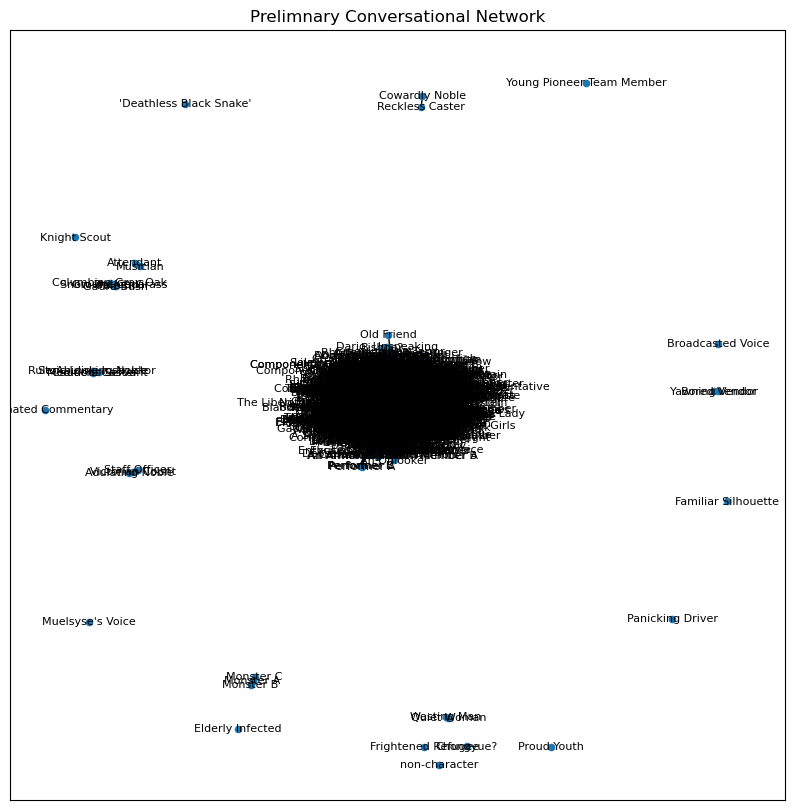

In [20]:

# Initialize an empty graph
G = nx.Graph()

# Add nodes (speakers) to the graph
for index, row in characters_df.iterrows():
    G.add_node(row['id'], meta=row.to_dict())  # Adding speaker metadata as node attributes

# Add edges based on interactions in each conversation
for convo_id in corpus.get_conversation_ids():
    conversation = corpus.get_conversation(convo_id)
    speakers = conversation.get_speaker_ids()

    # For each pair of speakers, add an edge if it doesn't already exist
    for i in range(len(speakers)):
        for j in range(i + 1, len(speakers)):
            if not G.has_edge(speakers[i], speakers[j]):
                G.add_edge(speakers[i], speakers[j])

# Plot the graph
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, with_labels=True, node_size=20, font_size=8)
plt.title('Prelimnary Conversational Network')
plt.show()

In [ ]:
degree_centrality = nx.degree_centrality(G)

# see top 10 character's degree_centrality

central_speakers = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:100]
central_speakers    



#### study the network of popular characters

In [33]:
# from online votes:

popular_chars = ['Skadi', 'Młynar', "Texas", "Amiya", 
                 "Exusiai", "SilverAsh", "Dusk", "Kal'tsit", 
                 "W", "Ch'en", "Saria", "Lappland"]

In [34]:
# get or conversations that contain those characters

convo_ids = []

for convo_id in corpus.get_conversation_ids():
    conversation = corpus.get_conversation(convo_id)
    speakers = conversation.get_speaker_ids()
    if any(speaker in popular_chars for speaker in speakers):
        convo_ids.append(convo_id)


In [32]:
from collections import defaultdict

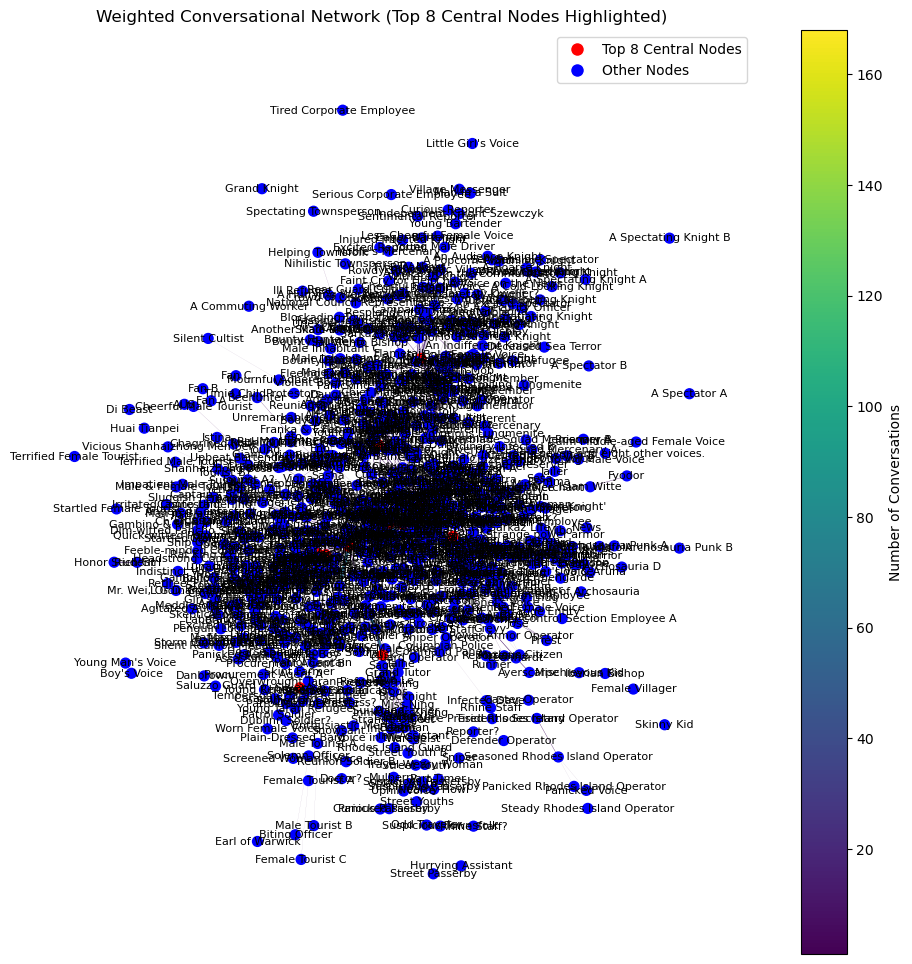

In [38]:
# Create a new graph
weighted_graph = nx.Graph()

# Keep track of the number of conversations between speakers
conversation_counts = defaultdict(int)

# Iterate through all conversation IDs involving the top 10 central nodes
for convo_id in convo_ids:
    conversation = corpus.get_conversation(convo_id)
    speaker_ids = conversation.get_speaker_ids()
    utterances_df = conversation.get_utterances_dataframe()
    utterances_df = utterances_df.reset_index()

    # Add nodes and update the edge weights
    for idx, row in utterances_df.iterrows():
        if idx < len(utterances_df) - 1:  # To ensure we don't go out of bounds
            this_row = utterances_df.iloc[idx]
            next_row = utterances_df.iloc[idx + 1]
            speaker1 = this_row['speaker']
            speaker2 = next_row['speaker']

            if speaker1 != speaker2:  # Ensure we don't count self-dialogue
                # Update the count in both directions as it's an undirected graph
                conversation_counts[(speaker1, speaker2)] += 1

                # Add speakers as nodes if they don't already exist in the graph
                weighted_graph.add_node(speaker1)
                weighted_graph.add_node(speaker2)

                # Add or update the edge with the new weight
                if weighted_graph.has_edge(speaker1, speaker2):
                    # If the edge already exists, update the weight
                    weighted_graph[speaker1][speaker2]['weight'] += 1
                else:
                    # Otherwise, add a new edge with weight 1
                    weighted_graph.add_edge(speaker1, speaker2, weight=1)


# # Add the edges with weights to the graph
# for (speaker1, speaker2), count in conversation_counts.items():
#     weighted_graph.add_edge(speaker1, speaker2, weight=count)

# Set up the color map for nodes
node_color_map = []
for node in weighted_graph:
    if node in popular_chars:
        node_color_map.append('red')  # Central nodes colored red
    else:
        node_color_map.append('blue')  # Other nodes colored blue

#####
# Define a colormap
cmap = plt.cm.viridis

# Extract weights and normalize them to use for edge colors/widths
weights = [data['weight'] for _, _, data in weighted_graph.edges(data=True)]
max_weight = max(weights)
min_weight = min(weights)
# Normalize weights to range [0, 1] for color mapping
norm_weights = [(w - min_weight) / (max_weight - min_weight) for w in weights]

# Extract edge weights for drawing
edge_weights = [data['weight'] for _, _, data in weighted_graph.edges(data=True)]


# Generate edge colors based on weights
edge_colors = [cmap(norm_weight) for norm_weight in norm_weights]


# # Draw the weighted graph
# plt.figure(figsize=(12, 12))
# pos = nx.spring_layout(weighted_graph)

# # Draw nodes with the color mapping
# nx.draw_networkx_nodes(weighted_graph, pos, node_color=node_color_map, node_size=500)

# # Draw edges with colors and varied width
# edges = nx.draw_networkx_edges(
#     weighted_graph,
#     pos,
#     edge_color=edge_colors,
#     width=[w * 5 for w in norm_weights]  # Adjust multiplier as needed for visibility
# )

# ... previous code ...

# Draw the weighted graph
fig, ax = plt.subplots(figsize=(12, 12))  # Create a figure and a set of subplots
pos = nx.spring_layout(weighted_graph)

# Draw nodes with the color mapping
nx.draw_networkx_nodes(weighted_graph, pos, node_color=node_color_map, node_size=50, ax=ax)

# Draw edges with colors and varied width
edges = nx.draw_networkx_edges(
    weighted_graph,
    pos,
    edge_color=edge_colors,
    width=[w * 5 for w in norm_weights],  # Adjust multiplier as needed for visibility
    ax=ax
)

nx.draw_networkx_labels(weighted_graph, pos, font_size=8, ax=ax)

# Add a legend
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Top 8 Central Nodes')
blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Other Nodes')
plt.legend(handles=[red_patch, blue_patch])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_weight, vmax=max_weight))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Number of Conversations')

# Set plot title and remove axes
plt.title('Weighted Conversational Network (Top 8 Central Nodes Highlighted)')
plt.axis('off')  # Hide axes
plt.show()
